In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-clothing-store/products_skus.csv
/kaggle/input/ecommerce-clothing-store/products.csv
/kaggle/input/ecommerce-clothing-store/traffic.csv
/kaggle/input/ecommerce-clothing-store/orders_items.csv
/kaggle/input/ecommerce-clothing-store/orders.csv
/kaggle/input/ecommerce-clothing-store/customers.csv
/kaggle/input/ecommerce-clothing-store/transactions.csv


### 1. Business Understanding

#### This project is based on a e-commerce clothing startup 👚👗👠👢. 
#### The goal is to explore customers and sales trends and behaviors to give the business some insights and strategies to boost sales 📦📦📦📦. 
#### Major analyses are as follows:
* traffic & sales trend analysis

### 2. Data Understanding

In [62]:
# load data
# customer => website (traffic) => product/product sku => order/order items => transaction
customers = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/customers.csv').rename(columns={'id':'customer_id', 'created_at':'customer_created_at'})
traffic = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/traffic.csv').drop(columns=['index'])
products = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/products.csv').rename(columns={'id':'product_id', 'title':'product_title', 'created_at':'product_created_at', 'published_at':'product_published_at'})
prod_sku = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/products_skus.csv').rename(columns={'id':'product_sku_id', 'created_at':'sku_created_at'})
orders = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/orders.csv').rename(columns={'id':'order_id', 'created_at':'order_created_at', 'closed_at':'order_closed_at', 'cancelled_at':'order_cancelled_at'})
ord_item = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/orders_items.csv').rename(columns={'id':'order_product_id'})
transactions = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/transactions.csv').rename(columns={'id':'transaction_id', 'created_at':'transaction_created_at'})

col_dict = {}
col_dict['customers'] = customers.columns.tolist()
col_dict['traffic'] = traffic.columns.tolist()
col_dict['products'] = products.columns.tolist()
col_dict['prod_sku'] = prod_sku.columns.tolist()
col_dict['orders'] = orders.columns.tolist()
col_dict['ord_item'] = ord_item.columns.tolist()
col_dict['transactions'] = transactions.columns.tolist()

print('customers:', col_dict['customers'])
print('traffic:', col_dict['traffic'])
print('products:', col_dict['products'])
print('prod_sku:', col_dict['prod_sku'])
print('orders:', col_dict['orders'])
print('ord_item:', col_dict['ord_item'])
print('transactions:', col_dict['transactions'])

customers: ['customer_id', 'full_name', 'customer_created_at']
traffic: ['date_day', 'page_views', 'sessions', 'product_detail_views', 'product_checkouts', 'product_adds_to_carts', 'avg_session_in_s']
products: ['product_id', 'product_title', 'product_type', 'product_created_at', 'product_published_at']
prod_sku: ['product_sku_id', 'product_id', 'product_style', 'sku', 'sku_created_at', 'price']
orders: ['order_id', 'order_created_at', 'order_closed_at', 'order_cancelled_at', 'customer_id', 'financial_status', 'fulfillment_status', 'processed_at', 'total_price', 'shipping_rate', 'subtotal_price', 'total_discounts', 'total_line_items_price']
ord_item: ['order_product_id', 'order_id', 'product_id', 'product_style', 'variant_id', 'sku', 'product_title', 'fulfillment_status', 'price', 'quantity']
transactions: ['order_id', 'transaction_id', 'parent_id', 'amount', 'error_code', 'kind', 'status', 'transaction_created_at']


#### No. Customers:

In [30]:
print("There are {} customers, {} don't have full names.".format(customers['customer_id'].nunique(), customers['full_name'].isnull().sum()))
print("{} are unique full names and {} are duplicates.".format(customers['full_name'].nunique(), customers['customer_id'].nunique() - customers['full_name'].nunique()))

There are 44661 customers, 10962 don't have full names.
28638 are unique full names and 16023 are duplicates.


#### Traffic (Pageviews):

Avg. daily # pageviews = 18542
Medium. daily # pageviews = 10417
# outliers = 9 [625003, 220707, 226285, 137956, 169100, 187239, 192006, 136682, 160544]


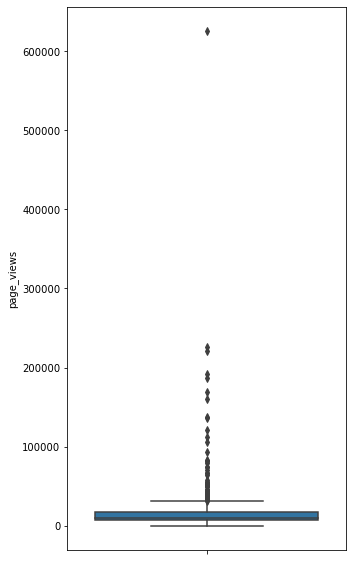

In [61]:
plt.figure(figsize=(5,10))
sns.boxplot(data=traffic, y='page_views')
print('Avg. daily # pageviews = {:.0f}'.format(traffic['page_views'].mean()))
print('Medium. daily # pageviews = {:.0f}'.format(traffic['page_views'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['page_views'])) > 3, 'page_views'].count(), traffic.loc[np.abs(stats.zscore(traffic['page_views'])) > 3, 'page_views'].tolist()))

* #### No. Product Detail Pageviews:

Avg. daily # pageviews = 18542
Median daily # pageviews = 10417
# outliers = 9 [625003, 220707, 226285, 137956, 169100, 187239, 192006, 136682, 160544]


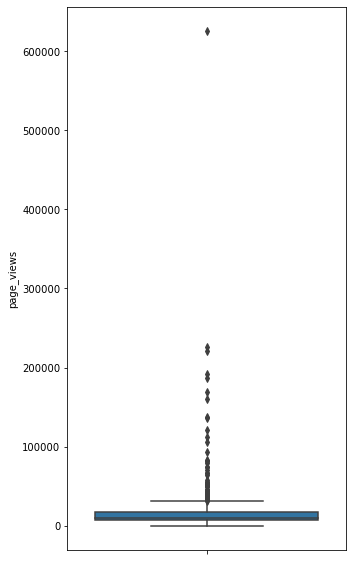

In [69]:
plt.figure(figsize=(5,10))
sns.boxplot(data=traffic, y='page_views')
print('Avg. daily # pageviews = {:.0f}'.format(traffic['page_views'].mean()))
print('Median daily # pageviews = {:.0f}'.format(traffic['page_views'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['page_views'])) > 3, 'page_views'].count(), traffic.loc[np.abs(stats.zscore(traffic['page_views'])) > 3, 'page_views'].tolist()))

Avg. daily # product detail pageviews = 4957
Median daily # product detail pageviews = 2670
# outliers = 8 [175257, 58940, 65644, 34996, 60816, 60005, 57313, 40927]


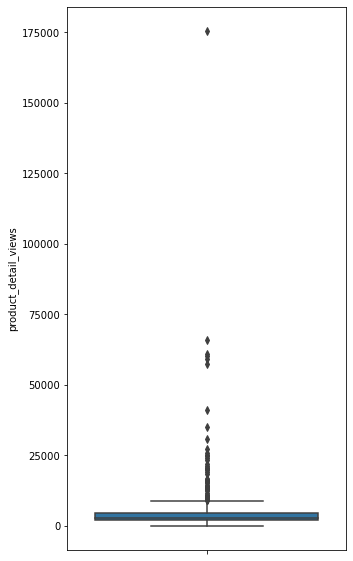

In [70]:
plt.figure(figsize=(5,10))
sns.boxplot(data=traffic, y='product_detail_views')
print('Avg. daily # product detail pageviews = {:.0f}'.format(traffic['product_detail_views'].mean()))
print('Median daily # product detail pageviews = {:.0f}'.format(traffic['product_detail_views'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['product_detail_views'])) > 3, 'product_detail_views'].count(), traffic.loc[np.abs(stats.zscore(traffic['product_detail_views'])) > 3, 'product_detail_views'].tolist()))

#### No. Add2Carts:

Avg. daily # add-to-carts = 499
Median daily # add-to-carts = 262
# outliers = 9 [10851, 4763, 4301, 5700, 9450, 3408, 8299, 3273, 4434]


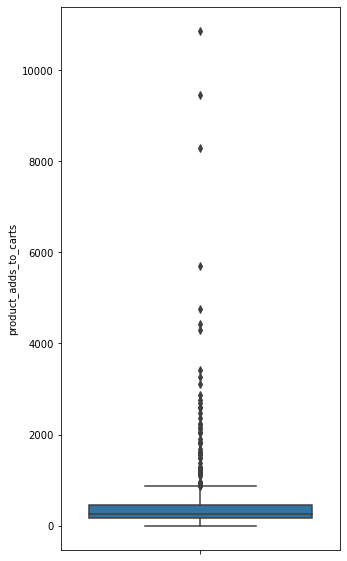

In [73]:
plt.figure(figsize=(5,10))
sns.boxplot(data=traffic, y='product_adds_to_carts')
print('Avg. daily # add-to-carts = {:.0f}'.format(traffic['product_adds_to_carts'].mean()))
print('Median daily # add-to-carts = {:.0f}'.format(traffic['product_adds_to_carts'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['product_adds_to_carts'])) > 3, 'product_adds_to_carts'].count(), traffic.loc[np.abs(stats.zscore(traffic['product_adds_to_carts'])) > 3, 'product_adds_to_carts'].tolist()))

#### No. Checkouts:

Avg. daily # checkouts = 146
Medium daily # checkouts = 62
# outliers = 9 [5639, 2001, 1644, 1228, 1840, 1312, 1852, 1794, 1378]


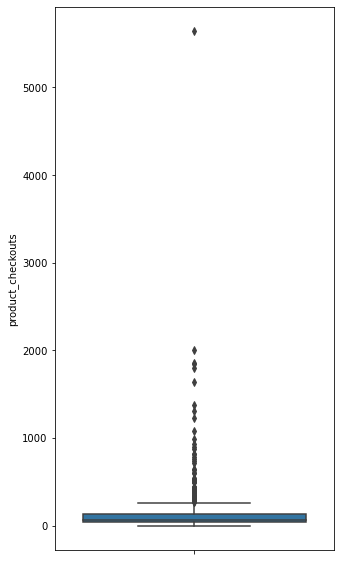

In [68]:
plt.figure(figsize=(5,10))
sns.boxplot(data=traffic, y='product_checkouts')
print('Avg. daily # checkouts = {:.0f}'.format(traffic['product_checkouts'].mean()))
print('Median daily # checkouts = {:.0f}'.format(traffic['product_checkouts'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['product_checkouts'])) > 3, 'product_checkouts'].count(), traffic.loc[np.abs(stats.zscore(traffic['product_checkouts'])) > 3, 'product_checkouts'].tolist()))

#### Sessions:

Avg. daily # sessions = 4461
Median daily # sessions = 2693
# outliers = 9 [146860, 61654, 46927, 31815, 31239, 32166, 36614, 45385, 35921]


Avg. of daily average session in seconds = 145.32655160450236
Median. of daily average session in seconds = 132.607292539816
# outliers = 4 [2374.16666666667, 1632.11111111111, 1891.25, 1557.95652173913]


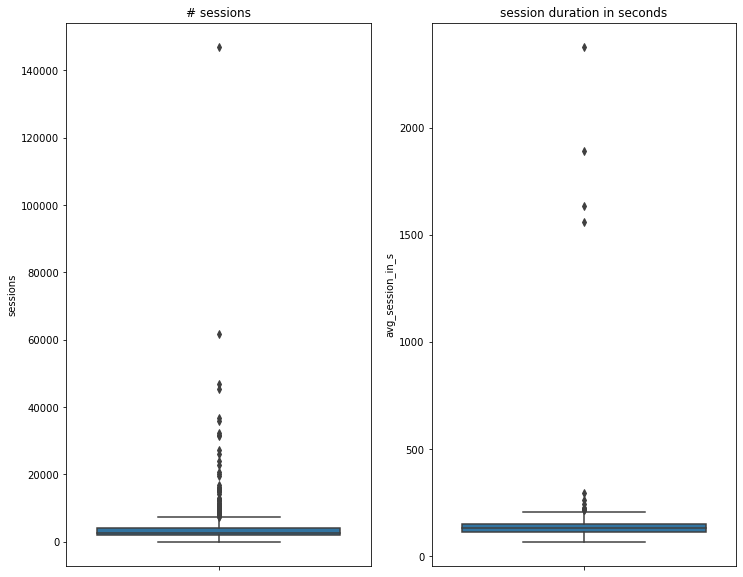

In [87]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
sns.boxplot(data=traffic, y='sessions', ax=ax1)
ax1.set_title('# sessions')
sns.boxplot(data=traffic, y='avg_session_in_s', ax=ax2)
ax2.set_title('session duration in seconds')
print('Avg. daily # sessions = {:.0f}'.format(traffic['sessions'].mean()))
print('Median daily # sessions = {:.0f}'.format(traffic['sessions'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['sessions'])) > 3, 'sessions'].count(), traffic.loc[np.abs(stats.zscore(traffic['sessions'])) > 3, 'sessions'].tolist()))
print('\n')
print('Avg. of daily average session in seconds = {}'.format(traffic['avg_session_in_s'].mean()))
print('Median. of daily average session in seconds = {}'.format(traffic['avg_session_in_s'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['avg_session_in_s'])) > 3, 'avg_session_in_s'].count(), traffic.loc[np.abs(stats.zscore(traffic['avg_session_in_s'])) > 3, 'avg_session_in_s'].tolist()))

#### Products:

There are 247 products and 26 product types.
* Hooide==hoodie, Tousers==Trousers, and mixed-cases to be improved...


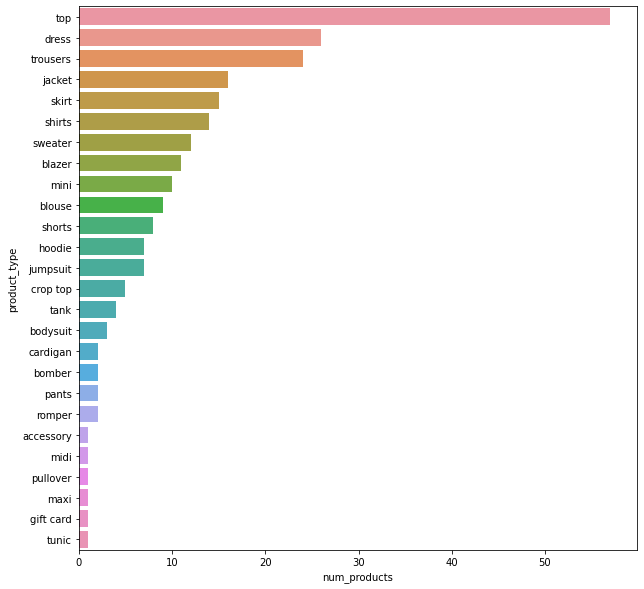

In [144]:
print('There are {} products and {} product types.'.format(products['product_id'].nunique(), products['product_type'].nunique()))
print('* Hooide==hoodie, Tousers==Trousers, and mixed-cases to be improved...')

products['product_type'] = products['product_type'].str.lower()
products.loc[lambda x: x['product_type'] == 'tousers', 'product_type'] = 'trousers'
products.loc[lambda x: x['product_type'] == 'hooide', 'product_type'] = 'hoodie'
plt.figure(figsize=(10, 10))
sns.barplot(data=products.groupby(['product_type'])['product_id'].count().reset_index().rename(columns={'product_id':'num_products'}).sort_values(by=['num_products'], ascending=False), 
            x='num_products',
            y='product_type');

#### Product SKU (Stock Keeping Unit):

In [127]:
col_dict['prod_sku']

['product_sku_id',
 'product_id',
 'product_style',
 'sku',
 'sku_created_at',
 'price']

In [145]:
print('There are {} SKUs, which means some products have multiple SKUs.'.format(prod_sku['sku'].nunique()))

There are 1353 SKUs, which means some products have multiple SKUs.


There are 5 outliers, [['gift card', 300.0], [nan, 150.0], [nan, 150.0], [nan, 150.0], [nan, 150.0]]


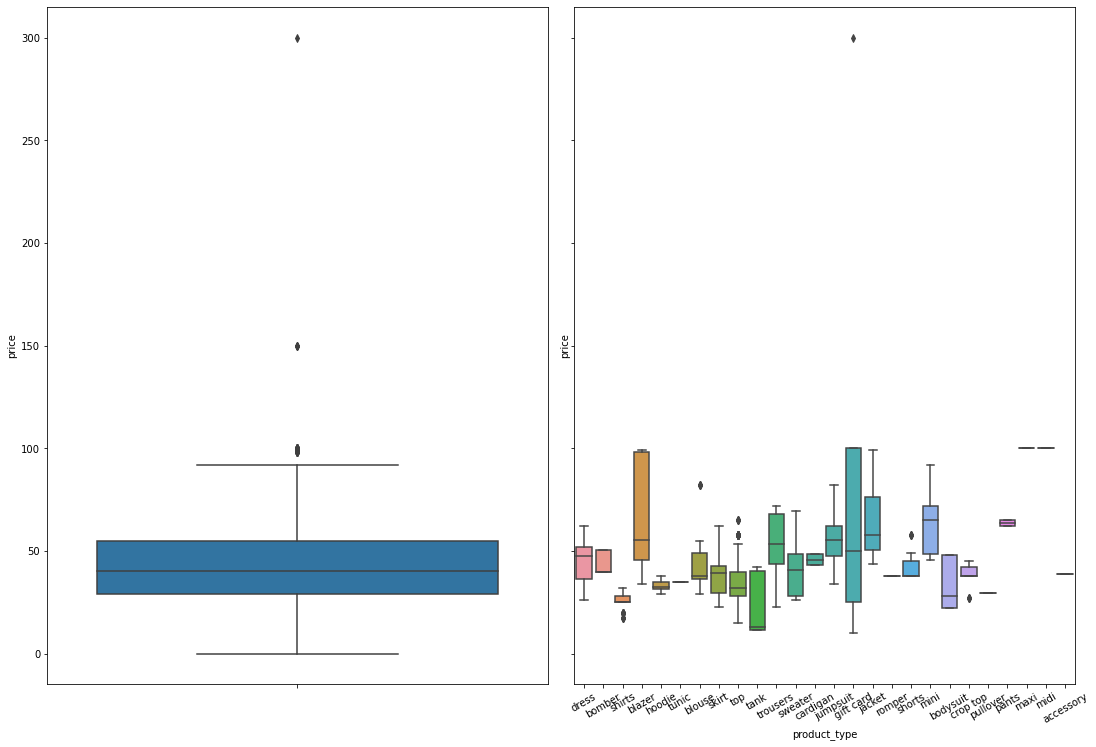

In [162]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharey=True)
fig.tight_layout()
sns.boxplot(data=prod_sku, y='price', ax=ax1)
sns.boxplot(data=pd.merge(products, prod_sku, on='product_id'), y='price', x='product_type', ax=ax2)
ax2.set_xticklabels(labels=ax2.get_xticklabels(), rotation=30);
print('There are {} outliers: {}'.format(prod_sku.loc[np.abs(stats.zscore(prod_sku['price'])) > 3].shape[0], pd.merge(products, prod_sku, on='product_id').loc[lambda x: np.abs(stats.zscore(x['price'])) > 3, ['product_type', 'price']].values.tolist()))

### 3. Data Preparation

### 1. How’s the trend of website traffic and the number of orders over time? 
- Is there any correlation between the orders and the website traffic?

In [ ]:
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))
plt.figure(figsize=(20, 5))
plt.ylim((0, 250000))
# pageview - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='page_views')
# sessions - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='sessions')
# prduct detail view - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='product_detail_views')
# product add to cart - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='product_adds_to_carts')
# product checkouts - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='product_checkouts')
# avg session s - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='avg_session_in_s')

In [ ]:
# order - time
order_by_time = orders.groupby(['created_at'])['id'].nunique().reset_index().rename(columns={'id':'num_order_created'})
order_by_time_no_can = orders.loc[lambda x: x['cancelled_at'].isnull()].groupby(['created_at'])['id'].nunique().reset_index().rename(columns={'id':'num_order_created'})

plt.figure(figsize=(20, 5))
sns.lineplot(data=order_by_time, x='created_at', y='num_order_created')

In [ ]:
cor_traf_time = traffic.merge(order_by_time, 
                              left_on='date_day',
                              right_on='created_at').sort_values(by=['date_day'])
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
sns.scatterplot(data=cor_traf_time, y='page_views', x='num_order_created', ax=ax1)
sns.scatterplot(data=cor_traf_time, y='sessions', x='num_order_created', ax=ax2)
sns.scatterplot(data=cor_traf_time, y='product_detail_views', x='num_order_created', ax=ax3)
sns.scatterplot(data=cor_traf_time, y='product_adds_to_carts', x='num_order_created', ax=ax4)
sns.scatterplot(data=cor_traf_time, y='product_checkouts', x='num_order_created', ax=ax5)

cor_traf_time_no_can = traffic.merge(order_by_time_no_can, 
                                     left_on='date_day',
                                     right_on='created_at').sort_values(by=['date_day'])
sns.scatterplot(data=cor_traf_time_no_can, y='product_checkouts', x='num_order_created', ax=ax6)
ax6.set_ylabel('product_checkouts (no cancellation)')

In [ ]:
# 2. How’s the sales from the different products over the seasons or months? What are the popular products? Is there any correlation between different products?


In [ ]:
prod_order = pd.merge(ord_item[['order_id', 'product_id', 'price', 'quantity']],
         products[['id', 'product_type', 'created_at','published_at']].rename(columns={'id':'product_id', 'created_at':'prod_created_at'}),
         on='product_id').merge(orders[['id', 'created_at', 'closed_at', 'cancelled_at', 'total_price', 'shipping_rate', 'subtotal_price', 'total_discounts', 'total_line_items_price']].rename(columns={'id':'order_id', 'created_at':'ord_created_at', 'closed_at':'ord_closed_at', 'cancelled_at':'ord_cancelled_at'}), on='order_id').sort_values(by=['order_id', 'product_id'])
prod_order

In [ ]:
print('Total No. product types =', prod_order['product_type'].nunique())
prod_by_t = pd.pivot_table(prod_order,
               index='ord_created_at',
               columns='product_type',
               values='quantity',
               aggfunc=lambda x: sum(x),
               fill_value=0).reset_index().sort_values(by=['ord_created_at'])
prod_by_t.columns = [col.lower().replace(' ', '_') for col in prod_by_t.columns]
prod_by_t.head()

In [ ]:
print('Here we will start with top6 most bought product types to see the sales seasonal trends.')
top6_prod_type_list = ['top', 'dress', 'shirts', 'trousers', 'hoodie', 'sweater']
print('Top6:', top6_prod_type_list)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 20))
ind_list = np.arange(0, 577, 30)
for ax, col in zip((ax1, ax2, ax3, ax4, ax5, ax6), top6_prod_type_list):
    sns.lineplot(data=prod_by_t, x='ord_created_at', y=col, ax=ax)
    ax.set_xticks(ind_list)
    ax.set_xticklabels(labels=prod_by_t.loc[lambda x: x.index.isin(ind_list)]['ord_created_at'], rotation=15)
#plt.xticks(ticks=ind_list, labels=prod_by_t.loc[lambda x: x.index.isin(ind_list)]['ord_created_at'], rotation=30);

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(np.round(prod_by_t.drop(columns=['ord_created_at']).corr(), 3), annot=True);

In [ ]:
prod_order

In [ ]:
prod_order.loc[lambda x: (x['total_discounts'] > 0) & (x['order_id'] == 7705038559)]

In [ ]:
# 3. How’s the sales of different products with discount? Does the discount promote sales?
prod_order['total_discounts_ratio'] = np.round((prod_order['total_line_items_price'] - prod_order['subtotal_price']) / prod_order['total_line_items_price'], 4)

# In general
plt.figure(figsize=(10, 10))
sns.boxplot(data=prod_order, y='total_discounts_ratio', x='quantity')

In [ ]:
#customers: ['id', 'full_name', 'created_at']
#orders: ['id', 'created_at', 'closed_at', 'cancelled_at', 'customer_id',
#         'financial_status', 'fulfillment_status', 'processed_at', 'total_price',
#         'shipping_rate', 'subtotal_price', 'total_discounts',
#         'total_line_items_price']
#transactions: ['order_id', 'id', 'parent_id', 'amount', 'error_code', 'kind', 'status', 'created_at']

In [ ]:
customer_order = pd.merge(customers.rename(columns={'id':'customer_id', 'created_at':'customer_created_at'}),
         orders.rename(columns={'id':'order_id', 'created_at':'order_created_at'}),
         on='customer_id',
         how='left')[['customer_id', 'full_name', 'customer_created_at', 'order_created_at', 'total_price']].sort_values(by=['customer_id', 'order_created_at'])
# monthly churn rate: number of consumed customers in month i who didn't consume in month i+1 / number of consumed customers in month i 
customer_order['y_m'] = customer_order['order_created_at'].apply(lambda x: x[:7] if type(x) == str else x)
churn = customer_order.groupby(['customer_id', 'full_name', 'y_m'])['order_created_at'].any().reset_index()

churn_id_list = [] 
for customer in churn['customer_id'].unique():
    for y_m in churn['y_m'].unique():
        churn_id_list.append([customer, y_m])
churn = pd.merge(pd.DataFrame(churn_id_list, columns=['customer_id', 'y_m']),
                 churn,
                 on=['customer_id', 'y_m'],
                 how='left').sort_values(by=['customer_id', 'y_m'])

In [ ]:
churn['is_active'] = churn['order_created_at'].apply(lambda x: 1 if x == True else 0)
churn['is_prev_active'] = churn['is_active'].shift(1).fillna(0)
churn.loc[(churn['is_prev_active'] == 1) & (churn['is_active'] == 0), 'is_churn'] = 1
churn['is_churn'] = churn['is_churn'].fillna(0)
churn.sort_values(by=['y_m'])
churn.groupby(['y_m']).apply(lambda x: x['is_churn'].sum() / x['is_prev_active'].sum()).reset_index()

In [ ]:
# 4. Dig more into the data and gain more insights, you can choose some E-commerce metrics or analysis (e.g. churn rate, conversion rate, retention rate, RFM analysis). 

In [ ]:
# 5. Based on the insights from all above questions, do you have any suggestion for the growth of sales?